In [1]:
#""" Defining the libraries """
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

2024-03-21 20:29:38.621543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 20:29:38.621642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 20:29:38.802610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting Up Data Generators for Emotion Recognition Model Training

In [3]:
emotions_dir = '../input/deeplearning/augmented/all_data/' 
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    emotions_dir, target_size=image_size,
    batch_size=batch_size, 
    class_mode='categorical', shuffle=True, subset='training')

validation_generator = train_datagen.flow_from_directory(
    emotions_dir, target_size=image_size,
    batch_size=batch_size, 
    class_mode='categorical', shuffle=True, subset='validation')

Found 28475 images belonging to 6 classes.
Found 7115 images belonging to 6 classes.


# Visualizing Training Images with Emotion Labels

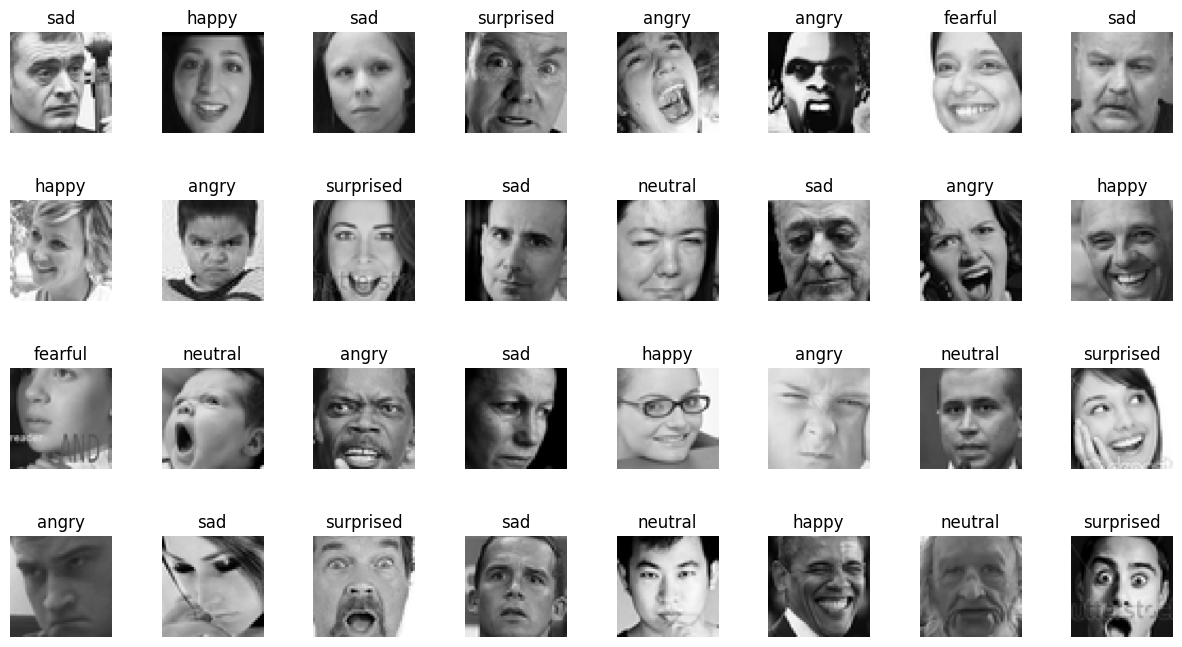

In [4]:
x_batch, y_batch = next(train_generator)
emotion_labels = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(4, 8, figsize=(15, 8))
axes = axes.ravel()

for i in np.arange(0, 4*8):
    axes[i].imshow(x_batch[i])
    axes[i].axis('off')
    emotion_idx = np.argmax(y_batch[i])
    axes[i].set_title(emotion_labels[emotion_idx])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

# Split the data into training and validation sets

In [5]:
num_classes = len(emotions)
num_classes 

6

In [6]:
# Split the data into training and validation sets
train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_generator[0][0], 
    train_generator[0][1], 
    test_size=0.2, 
    random_state=13
)

# Preparing Image and Label Data for Neural Network Training

In [7]:
# Convert the images and labels to numpy arrays
train_images = train_images.astype('float32')
validation_images = validation_images.astype('float32')
train_labels = to_categorical(train_labels, num_classes)
validation_labels = to_categorical(validation_labels, num_classes)

In [8]:
# Displaying the Dimensions of Training and Validation Datasets
print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Images Shape: {validation_images.shape}")
print(f"Validation Labels Shape: {validation_labels.shape}")

Training Images Shape: (25, 224, 224, 3)
Training Labels Shape: (25, 6, 6)
Validation Images Shape: (7, 224, 224, 3)
Validation Labels Shape: (7, 6, 6)


# Model 1 - Transfer Learning with VGG16 Architecture

In [12]:
# Initializing VGG16 Model for Feature Extraction with ImageNet Weights
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Freezing the Layers of the VGG16 Model to Prevent Weights from Being Updated
for layer in vgg16.layers:
    layer.trainable = False

In [14]:
# Adding Custom Layers to the Pre-trained VGG16 Model for a 6-Class Classification Task
num_classes=6
x = Flatten()(vgg16.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [30]:
# Constructing a New Model by Extending VGG16 for Custom Classification
model_1 = Model(vgg16.input, x)

In [16]:
# Configuring the Model with Adam Optimizer and Compiling for Categorical Classification
optimizer = Adam(learning_rate=1e-4)
model_1.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,411,974 (154.16 MB)

 Trainable params: 25,697,286 (98.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
# Train the model
history_1 = model_1.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/890 ━━━━━━━━━━━━━━━━━━━━ 8:10:59 33s/step - accuracy: 0.1875 - loss: 2.2710

I0000 00:00:1711031521.424548     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711031521.450087     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


239/890 ━━━━━━━━━━━━━━━━━━━━ 3:51 355ms/step - accuracy: 0.3388 - loss: 1.6700

W0000 00:00:1711031605.965366     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.4100 - loss: 1.5056

W0000 00:00:1711031754.081824     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 330s 334ms/step - accuracy: 0.4100 - loss: 1.5055 - val_accuracy: 0.5006 - val_loss: 1.3061
Epoch 2/10


W0000 00:00:1711031818.834666     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 144s 161ms/step - accuracy: 0.5505 - loss: 1.1838 - val_accuracy: 0.4665 - val_loss: 1.3876
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 144s 161ms/step - accuracy: 0.5859 - loss: 1.0874 - val_accuracy: 0.5445 - val_loss: 1.1882
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.6188 - loss: 1.0096 - val_accuracy: 0.5171 - val_loss: 1.2828
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 144s 161ms/step - accuracy: 0.6501 - loss: 0.9421 - val_accuracy: 0.5391 - val_loss: 1.2204
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.6795 - loss: 0.8619 - val_accuracy: 0.5105 - val_loss: 1.3461
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 144s 161ms/step - accuracy: 0.6975 - loss: 0.8326 - val_accuracy: 0.5543 - val_loss: 1.2097
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 144s 161ms/step - accuracy: 0.7277 - loss: 0.7547 - val_accuracy: 0.5241 - val_loss: 1.3230
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.7389 - loss: 0.72

# Model 2: Transfer Learning with VGG16 Architecture - Fine Tuning: Freezing Layers

In [42]:
# Initializing a Second VGG16 Model Base for Feature Extraction Without Top Layers"
base_model_2 = VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

In [43]:
# Freezing the First Layers of the Second VGG16 Model, Keeping the Last 10 Layers Trainable
for layer in base_model_2.layers[:-10]:
    layer.trainable = False

In [44]:
# Adding Flatten and Dense Layers to the Modified VGG16 Model for Classification
x = Flatten()(base_model_2.output)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

In [45]:
# Creating a New Model by Integrating Custom Layers with the Modified VGG16 Base
model_2 = Model(inputs=base_model_2.input, outputs=x)

In [46]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model_2.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,411,974 (154.16 MB)

 Trainable params: 39,266,566 (149.79 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [47]:
# Train the model
history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10


W0000 00:00:1711033943.665510     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


397/890 ━━━━━━━━━━━━━━━━━━━━ 1:46 215ms/step - accuracy: 0.2467 - loss: 1.7807

W0000 00:00:1711034045.177435     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.2841 - loss: 1.7074

W0000 00:00:1711034152.018010     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 257s 265ms/step - accuracy: 0.2842 - loss: 1.7073 - val_accuracy: 0.4800 - val_loss: 1.2988
Epoch 2/10


W0000 00:00:1711034179.573553     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 219s 245ms/step - accuracy: 0.5429 - loss: 1.1659 - val_accuracy: 0.5473 - val_loss: 1.1527
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 219s 246ms/step - accuracy: 0.6024 - loss: 1.0125 - val_accuracy: 0.5903 - val_loss: 1.0547
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 262s 246ms/step - accuracy: 0.6568 - loss: 0.9037 - val_accuracy: 0.5990 - val_loss: 1.0395
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 219s 246ms/step - accuracy: 0.7046 - loss: 0.7835 - val_accuracy: 0.6219 - val_loss: 1.0072
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 219s 245ms/step - accuracy: 0.7587 - loss: 0.6432 - val_accuracy: 0.6202 - val_loss: 1.0534
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 219s 246ms/step - accuracy: 0.8182 - loss: 0.4984 - val_accuracy: 0.6280 - val_loss: 1.1546
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 219s 246ms/step - accuracy: 0.8749 - loss: 0.3476 - val_accuracy: 0.6225 - val_loss: 1.2381
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 220s 246ms/step - accuracy: 0.9208 - loss: 0.22

# Model 3: Transfer Learning with VGG16 Architecture - Fine Tuning: Freezing layers / Including Dropout for Regularization

In [9]:
# Initializing a Third VGG16 Model for Feature Extraction with ImageNet Weights, Excluding the Top Layers
vgg16_3 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Setting the Layers Except for the Last Four of the Third VGG16 Model to Non-trainable
for layer in vgg16_3.layers[:-4]:
    layer.trainable = False

In [11]:
#Enhancing the Third VGG16 Model with Custom Layers, Including Dropout for Regularization
num_classes=6
x = Flatten()(vgg16_3.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Add dropout regularization
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)  # Add another dropout regularization
x = Dense(num_classes, activation='softmax')(x)

In [12]:
# Assembling a New Model by Combining the Adapted VGG16 Base with Custom Classification Layers
model_3 = Model(inputs=vgg16_3.input, outputs=x)

In [13]:
# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         3,07

 Total params: 40,933,702 (156.15 MB)

 Trainable params: 33,298,438 (127.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [14]:
# Train the model
history_3 = model_3.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/890 ━━━━━━━━━━━━━━━━━━━━ 9:17:55 38s/step - accuracy: 0.1562 - loss: 2.1422

I0000 00:00:1711053106.312966     129 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711053106.334725     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/890 ━━━━━━━━━━━━━━━━━━━━ 5:25 419ms/step - accuracy: 0.2397 - loss: 1.7852

W0000 00:00:1711053152.788334     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4133 - loss: 1.4491

W0000 00:00:1711053276.435194     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 257s 247ms/step - accuracy: 0.4134 - loss: 1.4489 - val_accuracy: 0.5500 - val_loss: 1.1417
Epoch 2/10


W0000 00:00:1711053325.785429     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.5895 - loss: 1.0610 - val_accuracy: 0.5822 - val_loss: 1.0833
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.6458 - loss: 0.9192 - val_accuracy: 0.6027 - val_loss: 1.0286
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.7029 - loss: 0.7879 - val_accuracy: 0.6233 - val_loss: 1.0056
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.7593 - loss: 0.6506 - val_accuracy: 0.6294 - val_loss: 1.0514
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 183ms/step - accuracy: 0.8172 - loss: 0.5043 - val_accuracy: 0.6195 - val_loss: 1.1744
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 184ms/step - accuracy: 0.8649 - loss: 0.3735 - val_accuracy: 0.6212 - val_loss: 1.3043
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 184ms/step - accuracy: 0.9066 - loss: 0.2621 - val_accuracy: 0.6236 - val_loss: 1.5162
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 164s 184ms/step - accuracy: 0.9382 - loss: 0.18

# Compare three Models

In [59]:
# Extract validation accuracy values from training history
accuracy_model_1 = history_1.history['val_accuracy']
accuracy_model_2 = history_2.history['val_accuracy']
accuracy_model_3 = history_3.history['val_accuracy']

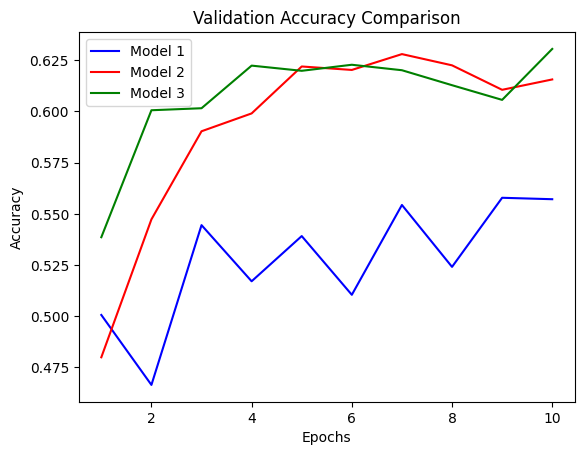

In [60]:
min_epochs = min(len(accuracy_model_1), len(accuracy_model_2), len(accuracy_model_3))
epochs = range(1, min_epochs + 1)

plt.plot(epochs, accuracy_model_1[:min_epochs], 'b', label='Model 1')
plt.plot(epochs, accuracy_model_2[:min_epochs], 'r', label='Model 2')
plt.plot(epochs, accuracy_model_3[:min_epochs], 'g', label='Model 3')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualizing how three Models Learn Over Time

# Model 1

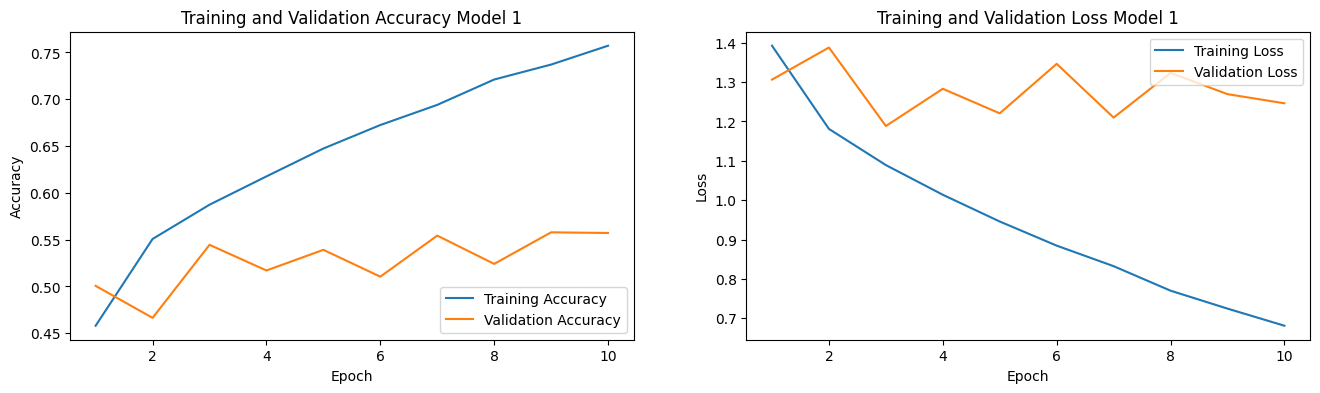

In [69]:
# Get the accuracy and loss values from the training history
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 1')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 1')

# Display the figure
plt.show()


# Model 2

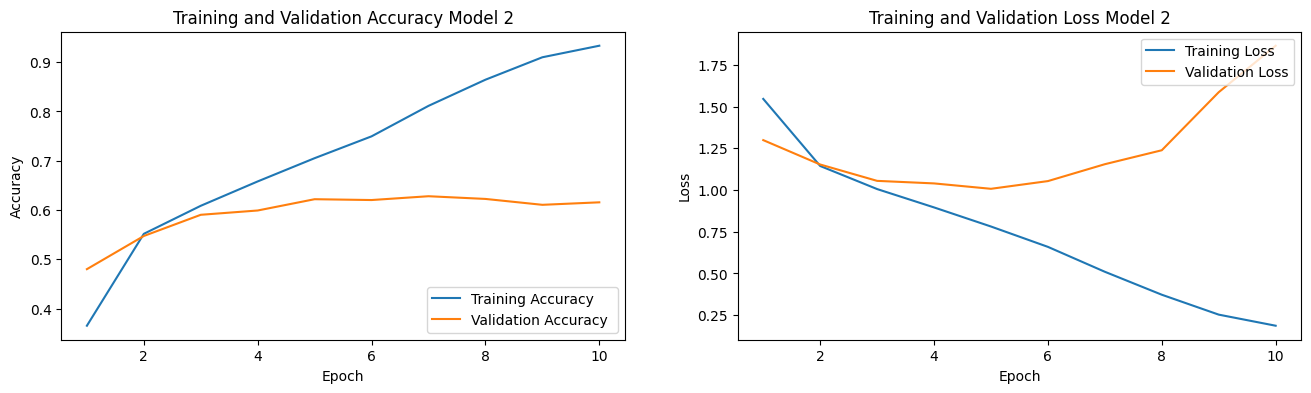

In [62]:
# Get the accuracy and loss values from the training history
train_acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy ')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 2')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 2')

# Display the figure
plt.show()


# Model 3

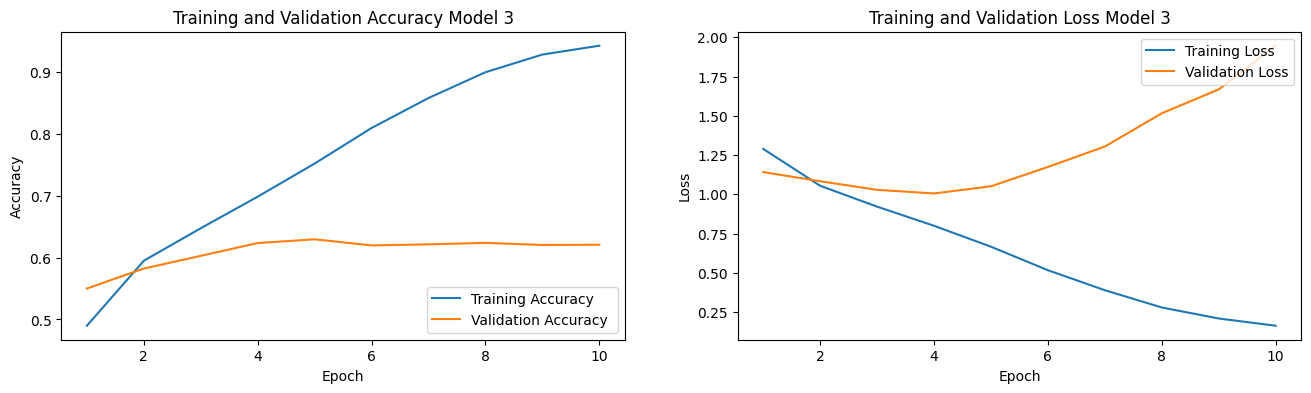

In [15]:
# Get the accuracy and loss values from the training history
train_acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
train_loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

# Set the x-axis to the number of epochs
epochs = range(1, len(train_loss) + 1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot the training and validation accuracy over each epoch
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy ')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy Model 3')

# Plot the training and validation loss over each epoch
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss Model 3')

# Display the figure
plt.show()


# Predict ramdom Images Using Best Model: Model 3

In [21]:
class_indices = train_generator.class_indices
class_names = dict((v, k) for k, v in class_indices.items())
class_names

{0: 'angry', 1: 'fearful', 2: 'happy', 3: 'neutral', 4: 'sad', 5: 'surprised'}

# Predict emotion from a randomly loaded image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[5.2045048e-06 4.2656795e-03 9.9735453e-06 1.4914754e-06 1.8375840e-06
  9.9571580e-01]]
Predicted class: 5


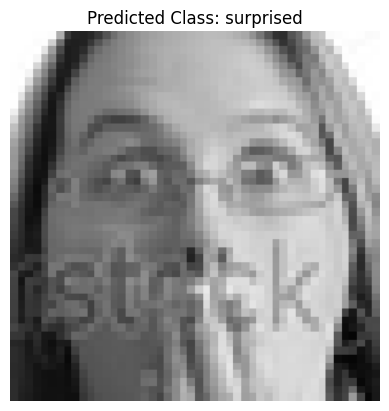

In [29]:
# We use best model and train set from another dataset to predict emotions
uploaded_image_path = '../input/emotion-detection-fer/test/surprised/im0.png' 

img = image.load_img(uploaded_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 

predictions = model_3.predict(img_array)
print(predictions)

predicted_class = np.argmax(predictions)

print("Predicted class:", predicted_class)

predicted_class_index = np.argmax(predictions)
predicted_class_name = class_names[predicted_class_index]
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()


# Predicting emotions using test subset from another dataset 

In [18]:
test_dir =  '../input/emotion-detection-fer/test/' 

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=image_size, 
    batch_size=batch_size, 
    class_mode='categorical', shuffle=False)

Found 7178 images belonging to 7 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


W0000 00:00:1711054853.255163     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


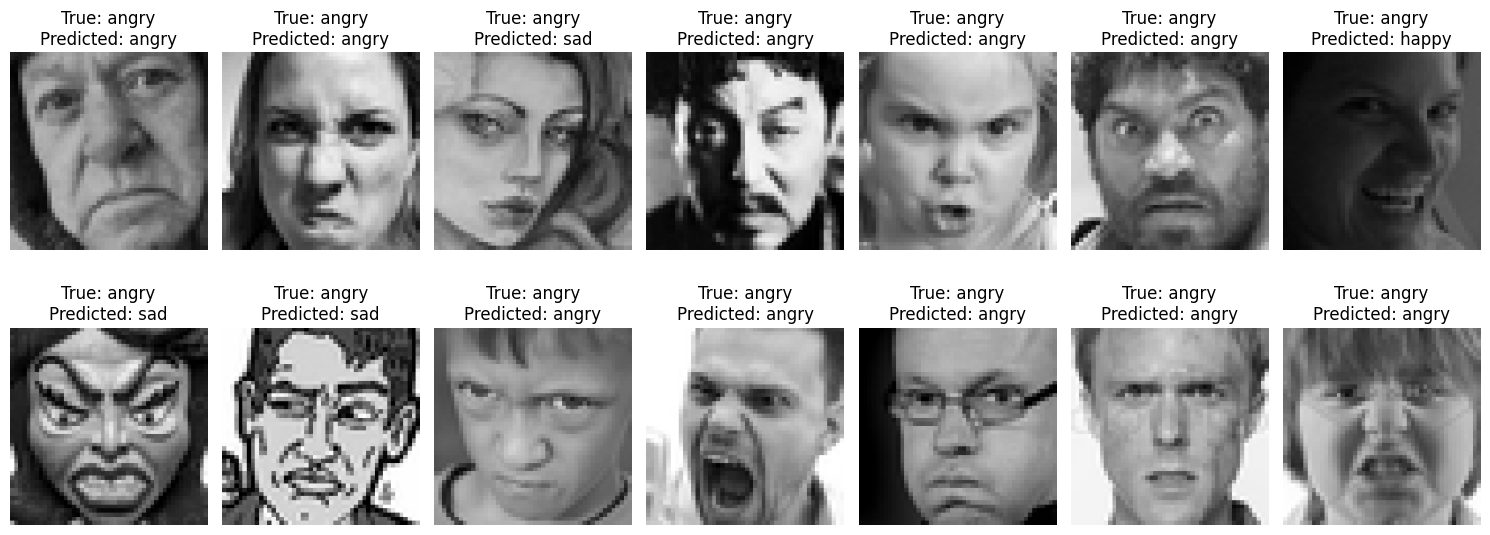

In [19]:
test_images = test_generator[0][0]
test_labels = test_generator[0][1]
predicted_labels = model_3.predict(test_images)
predicted_classes = np.argmax(predicted_labels, axis=1)

class_labels = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

num_images = 14
random_indices = np.random.choice(len(test_images), size=num_images, replace=False)

fig, axes = plt.subplots(2, 7, figsize=(15, 6))

for i, index in enumerate(random_indices):
    img = test_images[index]
    label = class_labels[np.argmax(test_labels[index])]
    predicted_label = class_labels[predicted_classes[index]]
    
    row = i // 7
    col = i % 7
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'True: {label}\nPredicted: {predicted_label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Saving Best Model

In [20]:
model_3.save('path_to_my_model_3.h5') 